# Lab 7: Heart Attack

# Setup

## Importing dependencies

In [1]:
pip install graphviz

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install pandas

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
from plotnine import *

from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, label_binarize
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix,\
                            classification_report, precision_score, recall_score, f1_score, roc_auc_score, auc, roc_curve, make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

## Reading in data

In [4]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")

In [5]:
ha.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1


## Column Descriptions

age : Age of the patient

sex : Sex of the patient

cp : Chest Pain type
- Value 1: typical angina
- Value 2: atypical angina
- Value 3: non-anginal pain
- Value 4: asymptomatic

trtbps : resting blood pressure (in mm Hg)

chol : cholesterol in mg/dl fetched via BMI sensor

restecg : resting electrocardiographic results
- Value 0: normal
- Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
- Value 2: showing probable or definite left ventricular hypertrophy by Estes’ criteria

thalach : maximum heart rate achieved during exercise

output : the doctor’s diagnosis of whether the patient is at risk for a heart attack
- 0 = not at risk of heart attack
- 1 = at risk of heart attack

## Data Cleaning

In [6]:
#mapping the CP categrories for clarity
# Define a mapping for the new categories
cp_mapping = {
    0: 'typical angina',
    1: 'atypical angina',
    2: 'non-anginal pain',
    3: 'asymptomatic'
}

# Replace values in the "cp" column with the new categories
ha['cp'] = ha['cp'].replace(cp_mapping)

# Display the updated dataset
#ha.head()

In [7]:
#mapping the restecg categrories for clarity
# Define a mapping for the new categories
restecg_mapping = {
    0: 'normal',
    1: 'abnormal',
    2: 'prob/def'
}

# Replace values in the "restecg" column with the new categories
ha['restecg'] = ha['restecg'].replace(restecg_mapping)

# Display the updated dataset
#ha.head()

In [8]:
# Define a mapping for the new categories
sex_mapping = {
    0: 'female',
    1: 'male',
}

# Replace values in the "sex" column with the new categories
ha['sex'] = ha['sex'].replace(sex_mapping)

# Convert the "sex" column to object type
ha['sex'] = ha['sex'].astype('object')

# Display the updated dataset
#ha.head()

In [9]:
# Define a mapping for the new categories
output_mapping = {
    0: 'not_at_risk',
    1: 'at_risk'
}

# Replace values in the "output" column with the new categories
ha['output'] = ha['output'].replace(output_mapping)

# Display the updated dataset
#ha.head()

In [10]:
# Display the updated dataset
ha.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,male,asymptomatic,145,233,normal,150,at_risk
1,37,male,non-anginal pain,130,250,abnormal,187,at_risk
2,56,male,atypical angina,120,236,abnormal,178,at_risk
3,57,female,typical angina,120,354,abnormal,163,at_risk
4,57,male,typical angina,140,192,abnormal,148,at_risk


## Preliminary Data Exploration

In [11]:
ha.describe()

,age,trtbps,chol,thalach
count,273.000000,273.000000,273.000000,273.000000
mean,54.347985,132.098901,246.860806,149.446886
std,9.163134,17.700358,52.569726,23.240707
min,29.000000,94.000000,126.000000,71.000000
25%,47.000000,120.000000,211.000000,133.000000
50%,56.000000,130.000000,240.000000,152.000000
75%,61.000000,140.000000,275.000000,166.000000
max,77.000000,200.000000,564.000000,202.000000


In [12]:
# Assuming 'ha' is your DataFrame
columns_of_interest = ['sex', 'output', 'cp', 'restecg']

for column in columns_of_interest:
    print(f"Value counts for {column}:\n{ha[column].value_counts()}\n")

Value counts for sex:
sex
male      184
female     89
Name: count, dtype: int64

Value counts for output:
output
at_risk        146
not_at_risk    127
Name: count, dtype: int64

Value counts for cp:
cp
typical angina      128
non-anginal pain     81
atypical angina      44
asymptomatic         20
Name: count, dtype: int64

Value counts for restecg:
restecg
abnormal    139
normal      130
prob/def      4
Name: count, dtype: int64



In [13]:
pd.crosstab(ha["output"], ha["sex"], normalize='index')

sex,female,male
output,,
at_risk,0.458904,0.541096
not_at_risk,0.173228,0.826772


# Part One: Fitting Models

In [14]:
#creating the target and the predictor variables
X= ha.drop(['output'], axis=1)
y= ha['output']

In [15]:
# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

## Q1: KNN

### Tuning KNN

In [16]:
#Preprocessor as a column transformer that dumifies, standardizes.
ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'), # what does the handle_unkow = 'ignore' do? sparse, array, handle, ignores unknown cats to 0
    make_column_selector(dtype_include=object)), #note the make_column_selector(dtype_include=object) will return all columns that are string objects.
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number)) #this one returns all columns that have numbers
  ],
  remainder = "passthrough" # we are doing this because we are keeping all the other variables
)

#Model Specification
knn = KNeighborsClassifier()

#pipeline Creation
model_1_pipeline = Pipeline(
    [("preprocessing", ct),
    ("knn_classification", knn)]
  )

In [17]:
#tuning using grid Search
params = {'knn_classification__n_neighbors': [1, 3, 5, 10, 50, 100]}

gscv = GridSearchCV(model_1_pipeline, params, cv = cv, scoring='roc_auc')

gscv_fitted = gscv.fit(X, y)

In [18]:
#getting the scores from the results
mean_test_scores = gscv_fitted.cv_results_['mean_test_score']

#getting the K's from the results corresponding to the
ks = gscv_fitted.cv_results_['param_knn_classification__n_neighbors']

# Creating a DataFrame with best parameterss and scores
model_scores = pd.DataFrame(data = {"K": ks, "roc_auc": mean_test_scores}).sort_values(by='roc_auc', ascending=False)
model_scores.head()

,K,roc_auc
4,50,0.828834
5,100,0.819594
3,10,0.816358
2,5,0.792350
1,3,0.784963


### Fitting Best KNN Model

- Utilizing GridSearchCV to tune the hyperparameter K for KNeighborsClassifier
  We find that the best value for K is 50 with accuracy roc_auc score of 0.83%.
- We move onto fitting this model on the DataSet to get the other metrics

In [19]:
# Model Specification
knn = KNeighborsClassifier(n_neighbors=50)

# pipeline Creation
model_1_pipeline = Pipeline(
    [("preprocessing", ct),
    ("knn_classification", knn)]
  )

#cross validated predictions
model_1_pred = cross_val_predict(model_1_pipeline, X, y, cv=cv)

# Metrics for Model 1
print("Metrics for Model_1 :\n")

# ROC AUC calculation
cv_scores = cross_val_score(model_1_pipeline, X, y, cv=cv, scoring='roc_auc_ovo') # Perform cross-validation
roc_auc_model_1 = np.mean(cv_scores)
print("Mean AUC Score:", roc_auc_model_1, "\n") # AUC Score

# Confusion matrix
uni_classes = y.unique() #getting the unique classes in the Y variale
conf_matrix_test = confusion_matrix(y, model_1_pred) # making the matrix
class_names = uni_classes.tolist() # Putting the classes to a list
conf_matrix_df = pd.DataFrame(conf_matrix_test, index=class_names, columns=class_names) # Display the confusion matrix with class labels
print("Confusion Matrix for Model_1 : \n")
conf_matrix_df

Metrics for Model_1 :

Mean AUC Score: 0.828833943833944 

Confusion Matrix for Model_1 : 



,at_risk,not_at_risk
at_risk,105,41
not_at_risk,30,97


## Q2: Logistic Regression

### Tuning Logistic Regression

In [20]:
#Model Specification
logreg = LogisticRegression(penalty='elasticnet',solver='saga')

#pipeline Creation
model_2_pipeline = Pipeline(
    [("preprocessing", ct),
    ("logisticreg_classification", logreg)]
  )

In [21]:
#tuning using grid Search
params = {'logisticreg_classification__C': [.0001, .001, .01, .1, 1, 10],
          'logisticreg_classification__l1_ratio':[.1, .2, .4, .6, .8, .9]}

gscv = GridSearchCV(model_2_pipeline, params, cv = cv, scoring='roc_auc')

gscv_fitted = gscv.fit(X, y)

In [22]:
#getting the scores from the results
mean_test_scores = gscv_fitted.cv_results_['mean_test_score']

#getting the parameters corresponding to the models from the results
lambdas = gscv_fitted.cv_results_['param_logisticreg_classification__C']
alphas = gscv_fitted.cv_results_['param_logisticreg_classification__l1_ratio']

# Creating a DataFrame with best parameterss and scores
model_scores = pd.DataFrame(data = {"lambdas": lambdas,"alphas": alphas, "roc_auc": mean_test_scores}).sort_values(by='roc_auc', ascending=False)
model_scores.head()

,lambdas,alphas,roc_auc
29,1.0,0.9,0.859689
28,1.0,0.8,0.859176
27,1.0,0.6,0.858071
26,1.0,0.4,0.855897
35,10.0,0.9,0.855855


### Fitting Tuned Logistic Regression Model

- After Tuning a Logistic Regression Models Hyperparameters, specifically by penalizing using Elastic net and tuning the lambda and alpha values to maximize the ROC_AUC Score, the best lambda and alpha values were 1 and .9 respectively with a ROC_AUC score of .86.
- We go forward with that model to get other metrics.

In [23]:
#Model Specification
logreg = LogisticRegression(penalty='elasticnet',solver='saga', C=1, l1_ratio=.9)

#pipeline Creation
model_2_pipeline = Pipeline(
    [("preprocessing", ct),
    ("logisticreg_classification", logreg)]
  )

#predictions for the test data
model_2_test_pred = cross_val_predict(model_2_pipeline, X, y, cv=cv)

# Metrics for Model 2
print("Metrics for Model_2 :\n")

# ROC AUC calculation
cv_scores = cross_val_score(model_2_pipeline, X, y, cv=cv, scoring='roc_auc_ovo') # Perform cross-validation
roc_auc_model_2 = np.mean(cv_scores)
print("Mean AUC Score:", roc_auc_model_2, "\n") # AUC Score

# Confusion matrix
uni_classes = y.unique() #getting the unique classes in the Y variale
conf_matrix_test = confusion_matrix(y, model_2_test_pred) # making the matrix
class_names = uni_classes.tolist() # Putting the classes to a list
conf_matrix_df = pd.DataFrame(conf_matrix_test, index=class_names, columns=class_names) # Display the confusion matrix with class labels
print("Confusion Matrix for Model_2 : \n")
conf_matrix_df

Metrics for Model_2 :

Mean AUC Score: 0.8596886446886447 

Confusion Matrix for Model_2 : 



,at_risk,not_at_risk
at_risk,119,27
not_at_risk,34,93


### Linear Model Coefficient Interpretation

In [24]:
# Perform cross-validated predictions
y_pred_cv = cross_val_predict(model_2_pipeline, X, y, cv=cv)

# Get the indices of correctly classified instances
correct_indices = (y == y_pred_cv)

# Use the correct indices to fit the model on the entire dataset
model_2_pipeline.fit(X[correct_indices], y[correct_indices])

# Extract coefficients
model_2_coef = model_2_pipeline.named_steps['logisticreg_classification'].coef_ # Extracting the Coefficients
flattened_coef = model_2_coef.flatten() # Flatten the 2D coefficient array

# Extract features
model_2_features = ct.get_feature_names_out()

# Create a dataframe
features_coeff = pd.DataFrame({'Feature': model_2_features, 'Coefficient': flattened_coef})

# Display the dataframe
#features_coeff

### log odds ratio to odds ratio, Function


In [25]:
# getting the odds ratio function
def destandardized_odds_ratio(feature, coefficient, original_data):
    if 'standardize__' in feature:
        original_feature = feature.replace('standardize__', '')
        std_value = original_data[original_feature].std()
        odds_ratio = np.exp(coefficient * std_value)
        return odds_ratio
    else:
        return np.exp(coefficient)

### Continue Linear Model Coefficient Interpretation

In [26]:
# Apply the transformation function to create a new column 'Original_Coefficient'
features_coeff['Odds_Ratio'] = features_coeff.apply(lambda row: destandardized_odds_ratio(row['Feature'], row['Coefficient'], ha), axis=1)

# Add a new column 'Absolute_Coefficient' to features_coeff
#features_coeff['Absolute_Coefficient'] = features_coeff['Odds_Ratio'].abs()

# Display the modified DataFrame
features_coeff.sort_values(by='Odds_Ratio', ascending=False).head() #printing it out

,Feature,Coefficient,Odds_Ratio
11,standardize__chol,0.833749,1.084209e+19
10,standardize__trtbps,0.881222,5.944259e+06
9,standardize__age,0.559861,1.690314e+02
5,dummify__cp_typical angina,4.676238,1.073654e+02
1,dummify__sex_male,1.695416,5.448910e+00


- the chances of somoeone being at risk according to our logistic regression model are increased the highest in terms of odds ratio by by chol (cholesterol in mg/dl fetched via BMI sensor), trtbps(resting blood pressure (in mm Hg)), age, cp (chest pain type: typical angina), and sex (Male).

## Q3: Decision Tree

### Tuning Decision Tree

In [27]:
#Preproccessor
ct_no_standardize = ColumnTransformer(
    [("dummify",
         OneHotEncoder(sparse_output=False, handle_unknown='ignore'),
         make_column_selector(dtype_include=object)),
    ],
    remainder="passthrough"
    )

#Model Specification
des = DecisionTreeClassifier()

#pipeline Creation
model_3_pipeline = Pipeline(
    [("preprocessing", ct_no_standardize),
    ("des_classification", des)]
  )

In [28]:
#tuning using grid Search
params = {'des_classification__max_depth': [1, 3, 6, 9, 12, 15]}

gscv = GridSearchCV(model_3_pipeline, params, cv = cv, scoring='roc_auc')

gscv_fitted = gscv.fit(X, y)

In [29]:
#getting the scores from the results
mean_test_scores = gscv_fitted.cv_results_['mean_test_score']

#getting the K's from the results corresponding to the
max_depth = gscv_fitted.cv_results_['param_des_classification__max_depth']

# Creating a DataFrame with best parameterss and scores
model_scores = pd.DataFrame(data = {"max_depth": max_depth, "roc_auc": mean_test_scores}).sort_values(by='roc_auc', ascending=False)
model_scores.head()

,max_depth,roc_auc
1,3,0.820870
0,1,0.754158
2,6,0.699527
5,15,0.685769
4,12,0.673901


### Fitting Tuned Decsion Tree Model

- After tuning the depth for the decision tree we found that the best max_depth to use was 3, yielding a roc_auc score of 82%.
- We go forward to fit this type of model on the data set to get our other metrics.

In [30]:
#Model Specification
des = DecisionTreeClassifier(max_depth=3)

#pipeline Creation
model_3_pipeline = Pipeline(
    [("preprocessing", ct_no_standardize),
    ("des_classification", des)]
  )

#predictions for the test data
model_3_test_pred = cross_val_predict(model_3_pipeline, X, y, cv=cv)

# Metrics for Model 3
print("Metrics for Model_3 :\n")

# ROC AUC calculation
cv_scores = cross_val_score(model_3_pipeline, X, y, cv=cv, scoring='roc_auc_ovo') # Perform cross-validation
roc_auc_model_3 = np.mean(cv_scores)
print("Mean AUC Score:", roc_auc_model_3, "\n") # AUC Score

# Confusion matrix
uni_classes = y.unique() #getting the unique classes in the Y variale
conf_matrix_test = confusion_matrix(y, model_3_test_pred) # making the matrix
class_names = uni_classes.tolist() # Putting the classes to a listconf_matrix_df = pd.DataFrame(conf_matrix_test, index=class_names, columns=class_names) # Display the confusion matrix with class labels
print("Confusion Matrix for Model_3 : \n")
conf_matrix_df

Metrics for Model_3 :

Mean AUC Score: 0.8208699633699634 

Confusion Matrix for Model_3 : 



,at_risk,not_at_risk
at_risk,119,27
not_at_risk,34,93


### Visualizing Tree

In [31]:
pip install graphviz


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [33]:
from sklearn.tree import export_graphviz
from IPython.display import display, Image
import graphviz

# Perform cross-validated predictions
y_pred_cv = cross_val_predict(model_3_pipeline, X, y, cv=cv)

# Get the indices of correctly classified instances
correct_indices = (y == y_pred_cv)

# Use the correct indices to fit the model on the entire dataset
model_3_pipeline.fit(X[correct_indices], y[correct_indices])

# Get the transformed feature names from the preprocessor
transformed_feature_names = list(ct_no_standardize.get_feature_names_out(X.columns))

# Export the decision tree to a DOT file
dot_data = export_graphviz(model_3_pipeline.named_steps['des_classification'],
                           feature_names=transformed_feature_names,
                           class_names=model_3_pipeline.named_steps['des_classification'].classes_,
                           filled=True,
                           rounded=True,
                           special_characters=True,
                           out_file=None)

# Render the decision tree directly in Colab
graph = graphviz.Source(dot_data, format="png")
#display(Image(graph.render(format='png', cleanup=True)))

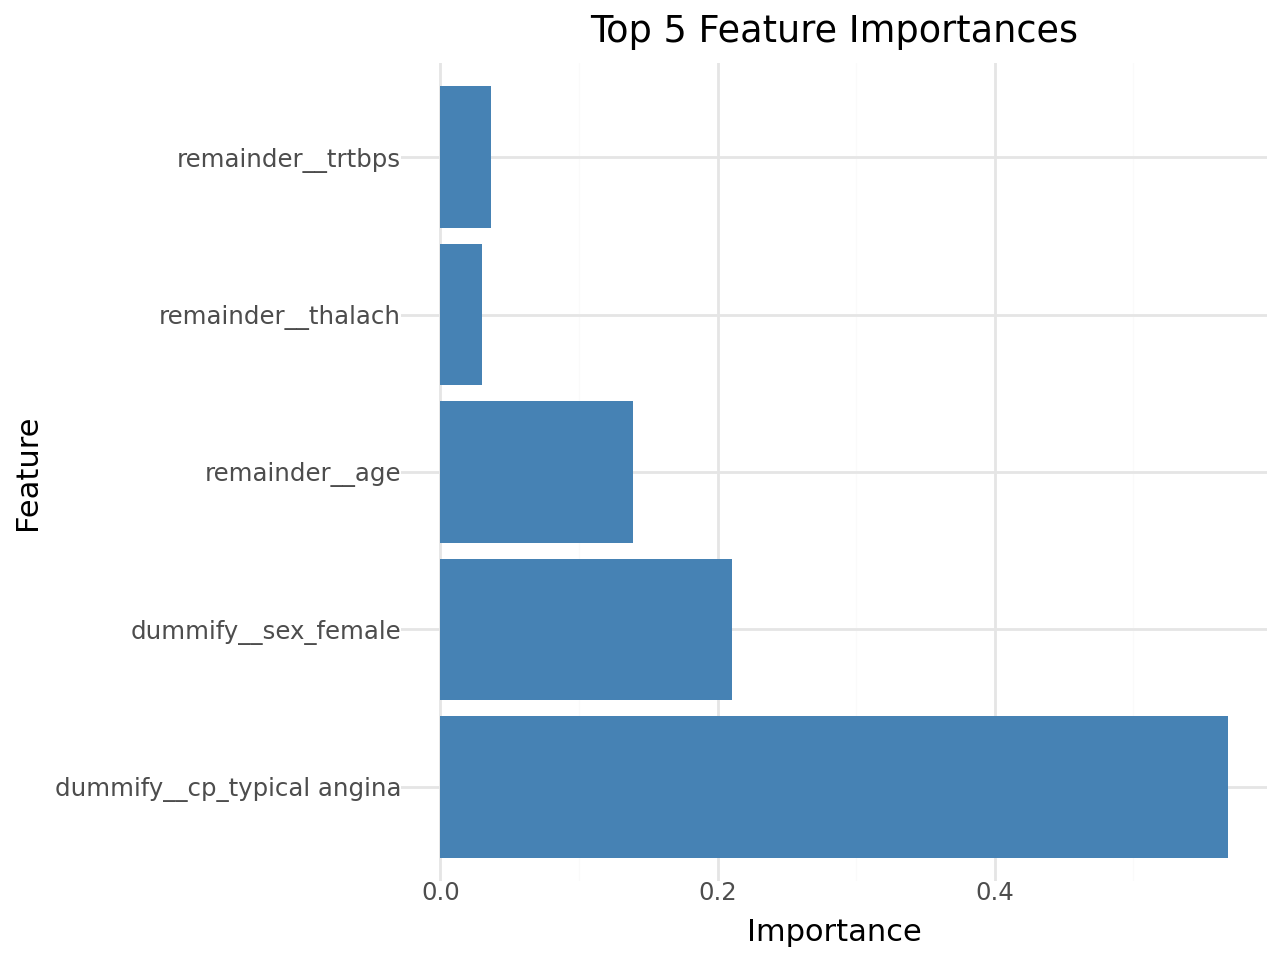

In [34]:
# Get feature importances
feature_importances = model_3_pipeline.named_steps["des_classification"].feature_importances_

# Get the corresponding feature names
feature_names = list(ct_no_standardize.get_feature_names_out(X.columns))

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the sorted feature importances
feature_importance_df.head()

feature_plot = (
    ggplot(feature_importance_df.head(), aes(x='Feature', y='Importance'))
    + geom_bar(stat='identity', fill='steelblue')
    + theme_minimal()
    + coord_flip()  # Horizontal bar plot
    + labs(title='Top 5 Feature Importances', x='Feature', y='Importance')
)
feature_plot
#feature_importance_df.head()

- the greatest classification factor according to our decision tree model for classifying whether someone is at risk of heart disease or not is cp (chest pain type typical angina), sex (Female), the next ones are age <=56, thalach (maximum heart rate achieved during exercise <= 160), and trtbps (resting blood pressure (in mm Hg) of <=107).

## Q4: Coefficients Interpretation

- the chances of somoeone being at risk according to our logistic regression model are increased the highest in terms of odds ratio by by chol (cholesterol in mg/dl fetched via BMI sensor), trtbps(resting blood pressure (in mm Hg)), age, cp (chest pain type: typical angina), and sex (Male).

- the greatest classification factor according to our decision tree model for classifying whether someone is at risk of heart disease or not is cp (chest pain type typical angina), sex (Female), the next ones are age <=56, thalach (maximum heart rate achieved during exercise <= 160), and trtbps (resting blood pressure (in mm Hg) of <=107).

## Q5: ROC Curve

In [35]:
# Models and their names
models = [model_1_pipeline, model_2_pipeline, model_3_pipeline]
model_names = ['Model 1', 'Model 2', 'Model 3']

# Create an empty DataFrame to store ROC curve data
roc_data_all = pd.DataFrame(columns=['False Positive Rate', 'True Positive Rate', 'Model', 'AUC Score'])

# Loop through models
for model, model_name in zip(models, model_names):
    # Perform cross-validated predictions
    y_scores = cross_val_predict(model, X, y, cv=cv, method='predict_proba')

    # Binarize the labels if needed
    y_binarized = label_binarize(y, classes=y.unique())

    # Calculate ROC curve and AUC for each class
    fpr, tpr, _ = roc_curve(y_binarized.ravel(), y_scores[:, 1].ravel())
    roc_auc = auc(fpr, tpr)

    # Create DataFrame for the current model
    roc_data_model = pd.DataFrame({'False Positive Rate': fpr, 'True Positive Rate': tpr, 'Model': model_name, 'AUC Score': roc_auc})

    # Append to the overall DataFrame
    roc_data_all = pd.concat([roc_data_all, roc_data_model], ignore_index=True)


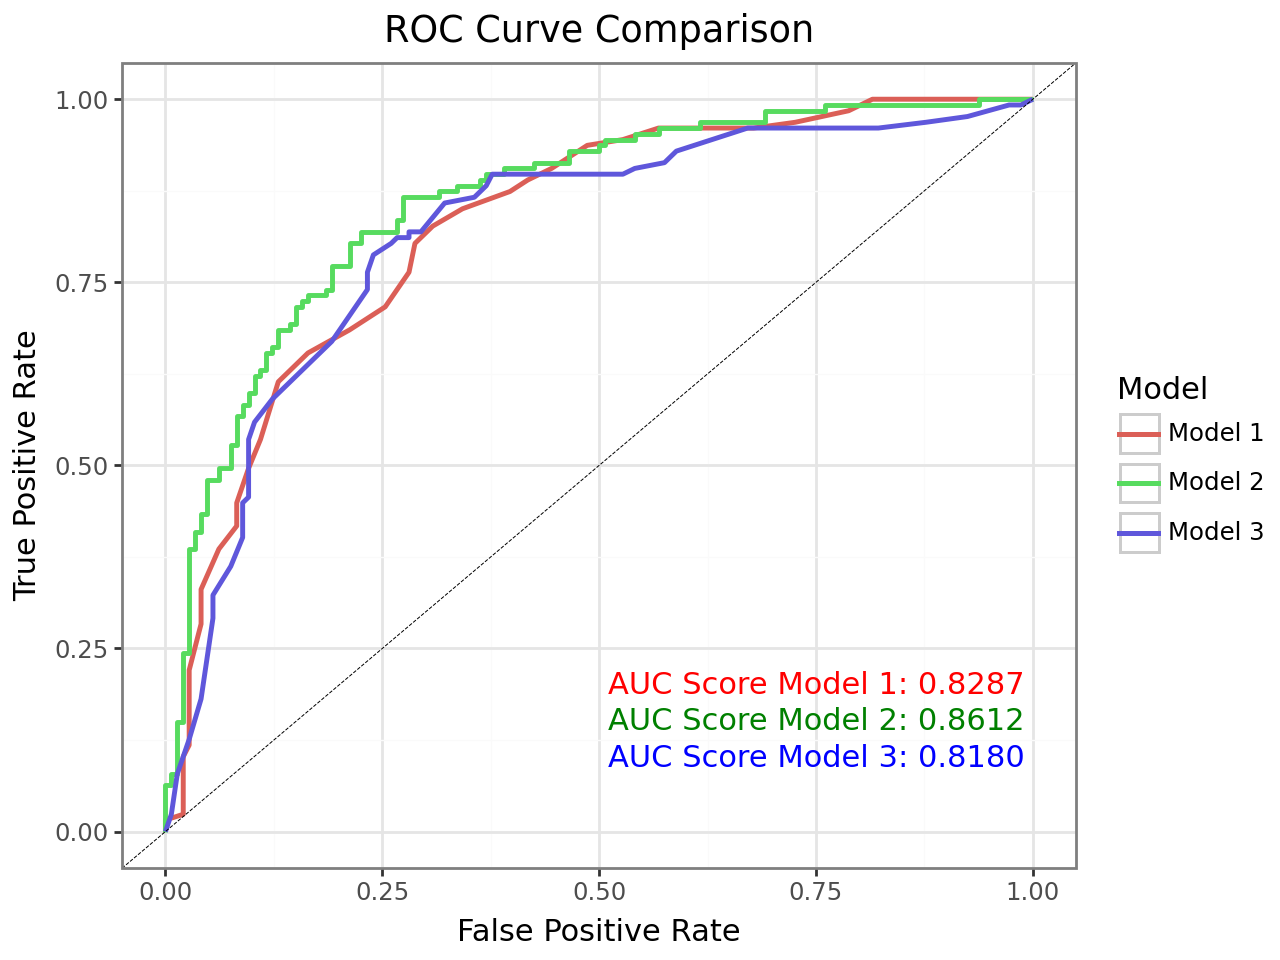

In [36]:

# Create ROC plot using plotnine
roc_plot_all = (
    ggplot(roc_data_all, aes(x='False Positive Rate', y='True Positive Rate', color='Model'))
    + geom_line(size = 1)
    + geom_abline(linetype='dashed', size=.2)
    + annotate("text", x=0.75, y=0.2, label=f"AUC Score {model_names[0]}: {roc_data_all[roc_data_all['Model'] == model_names[0]].iloc[0, 3]:.4f}", color="red")
    + annotate("text", x=0.75, y=0.15, label=f"AUC Score {model_names[1]}: {roc_data_all[roc_data_all['Model'] == model_names[1]].iloc[0, 3]:.4f}", color="green")
    + annotate("text", x=0.75, y=0.1, label=f"AUC Score {model_names[2]}: {roc_data_all[roc_data_all['Model'] == model_names[2]].iloc[0, 3]:.4f}", color="blue")
    + labs(title='ROC Curve Comparison', x='False Positive Rate', y='True Positive Rate')
    + theme_bw()
)


# Show the plot
print(roc_plot_all)

# Part Two: **Metrics**

In [37]:
# DataFrame for modles and their roc auc scores
roc_auc_data = pd.DataFrame({
    'Model': ['Model 1', 'Model 2', 'Model 3'],
    'ROC AUC Score': [roc_auc_model_1, roc_auc_model_2, roc_auc_model_3]
})

roc_auc_data

,Model,ROC AUC Score
0,Model 1,0.828834
1,Model 2,0.859689
2,Model 3,0.820870


## Model 1 kNN

In [38]:
# getting recall, precison and specificity
# Perform cross-validated predictions
y_pred_cv = cross_val_predict(model_1_pipeline, X, y, cv=cv)

# Generate a classification report
classification_rep_model_1 = pd.DataFrame(classification_report(y, y_pred_cv, digits=4, output_dict=True))

# Print the classification report
print(f"Classification Report Model 1: kNN (Cross-Validated):\n{classification_rep_model_1}\n")

# Extract the recall for 'at_risk', 'precison', 'specificity'
recall_model_1 = classification_rep_model_1['at_risk']['recall']
precision_model_1 = classification_rep_model_1['at_risk']['precision']
specificity_model_1 = classification_rep_model_1['not_at_risk']['recall']

# Print the recall value
print("Recall:", recall_model_1)
print("Precision:", precision_model_1)
print("Specificity:", specificity_model_1)

Classification Report Model 1: kNN (Cross-Validated):
              at_risk  not_at_risk  accuracy   macro avg  weighted avg
precision    0.777778     0.702899  0.739927    0.740338      0.742944
recall       0.719178     0.763780  0.739927    0.741479      0.739927
f1-score     0.747331     0.732075  0.739927    0.739703      0.740234
support    146.000000   127.000000  0.739927  273.000000    273.000000

Recall: 0.7191780821917808
Precision: 0.7777777777777778
Specificity: 0.7637795275590551


## Model 2 Logistic Regression

In [39]:
# Perform cross-validated predictions
y_pred_cv = cross_val_predict(model_2_pipeline, X, y, cv=cv)

# Generate a classification report
classification_rep_model_2 = pd.DataFrame(classification_report(y, y_pred_cv, digits=4, output_dict=True))

# Print the classification report
print(f"Classification Report Model 2: Penalized Logistic Regression (Cross-Validated):\n{classification_rep_model_2}\n")

# Extract the recall for 'at_risk', 'precison', 'specificity'
recall_model_2 = classification_rep_model_2['at_risk']['recall']
precision_model_2 = classification_rep_model_2['at_risk']['precision']
specificity_model_2 = classification_rep_model_2['not_at_risk']['recall']

# Print the recall value
print("Recall:", recall_model_2)
print("Precision:", precision_model_2)
print("Specificity:", specificity_model_2)

Classification Report Model 2: Penalized Logistic Regression (Cross-Validated):
              at_risk  not_at_risk  accuracy   macro avg  weighted avg
precision    0.777778     0.775000  0.776557    0.776389      0.776486
recall       0.815068     0.732283  0.776557    0.773676      0.776557
f1-score     0.795987     0.753036  0.776557    0.774512      0.776006
support    146.000000   127.000000  0.776557  273.000000    273.000000

Recall: 0.815068493150685
Precision: 0.7777777777777778
Specificity: 0.7322834645669292


## Model 3 Decission Tree

In [40]:
# Perform cross-validated predictions
y_pred_cv = cross_val_predict(model_3_pipeline, X, y, cv=cv)

# Generate a classification report
classification_rep_model_3 = pd.DataFrame(classification_report(y, y_pred_cv, digits=4, output_dict=True))

# Print the classification report
print(f"Classification Report Model 2: Decision Tree Classifier max_depth = 3 (Cross-Validated):\n{classification_rep_model_3}\n")

# Extract the recall for 'at_risk', 'precison', 'specificity'
recall_model_3 = classification_rep_model_3['at_risk']['recall']
precision_model_3 = classification_rep_model_3['at_risk']['precision']
specificity_model_3 = classification_rep_model_3['not_at_risk']['recall']

# Print the recall value
print("Recall:", recall_model_3)
print("Precision:", precision_model_3)
print("Specificity:", specificity_model_3)

Classification Report Model 2: Decision Tree Classifier max_depth = 3 (Cross-Validated):
              at_risk  not_at_risk  accuracy   macro avg  weighted avg
precision    0.816794     0.725352  0.769231    0.771073      0.774255
recall       0.732877     0.811024  0.769231    0.771950      0.769231
f1-score     0.772563     0.765799  0.769231    0.769181      0.769417
support    146.000000   127.000000  0.769231  273.000000    273.000000

Recall: 0.7328767123287672
Precision: 0.816793893129771
Specificity: 0.8110236220472441


# Part Three: Discussion

## Q1 The hospital faces severe lawsuits if they deem a patient to be low risk, and that patient later experiences a heart attack

- Here they would be concerned with minimizing the False Negative results which means that they would benefit from Recall as the metric by which to select a model. Since they are concerned with not telling someone they are not at risk when they actually are they would want to minimize the times they erroneously deem someone as low risk this is equivalent to minimizing false negatives which exists in the equation for recall.


- I would recommend the model that did the best at recall for the not_at_risk being model 3 with a cross validated recall score of 81%.

- For future observations we should expect about 81% in recall since this was a cross validated result.

## Q2 The hospital is overfull, and wants to only use bed space for patients most in need of monitoring due to heart attack risk.


- This situation seems to be one of concern of precision in identification of those at risk in order to miniize the instances of false positives which is measured by a models precision

- I would recommend that they utilize Model 3, a decision tree with all the variables utilzied as it had the highest cross validated score for precision on patients at risk.

- This model should be expected to yield a presicion score of about 81%.

## Q3 The hospital is studying root causes of heart attacks, and would like to understand which biological measures are associated with heart attack risk.

- The hospital should consider utilizing different decision tree models and assess their roc_auc scores as measures of how well the model will be predicting.

- I would recommend that they utilize model 3 which is a decision tree model as it will be simple for them to interpret the coefficients whcih have the greatest effect on risk of heart attack with a visualization and mathematical basis.

- If they decided to go with my model they should expect to have an AUC score of about 82%.

## Q4 The hospital is training a new batch of doctors, and they would like to compare the diagnoses of these doctors to the predictions given by the algorithm to measure the ability of new doctors to diagnose patients.

- In this instance it seems that the best measure of how well the doctors did in relation to a model would be best captured by using accuracy as measurement.

- If we wanted to utilize one of my models the suggestion would be Model 2, a logistic regression model that got an accuracy score of 78%.

- One could asses the doctors ability to see the number of correct predictions over the number of total predictions to asses what the accuracy was, with my model they can expect to compare themselves to a model with 78% accuracy.

# Part Four: Validation

In [41]:
ha_val = pd.read_csv("https://www.dropbox.com/s/jkwqdiyx6o6oad0/heart_attack_validation.csv?dl=1")

## Validation Data Cleaning

In [42]:
#mapping the CP categrories for clarity

# Define a mapping for the new categories
cp_mapping = {
    0: 'typical angina',
    1: 'atypical angina',
    2: 'non-anginal pain',
    3: 'asymptomatic'
}

# Replace values in the "cp" column with the new categories
ha_val['cp'] = ha_val['cp'].replace(cp_mapping)

# Display the updated dataset
#ha_val.head()

In [43]:
# Define a mapping for the new categories
restecg_mapping = {
    0: 'normal',
    1: 'abnormal',
    2: 'prob/def'
}

# Replace values in the "restecg" column with the new categories
ha_val['restecg'] = ha_val['restecg'].replace(restecg_mapping)

# Display the updated dataset
#ha_val.head()

In [44]:
# Define a mapping for the new categories
sex_mapping = {
    0: 'female',
    1: 'male',
}

# Replace values in the "restecg" column with the new categories
ha_val['sex'] = ha_val['sex'].replace(sex_mapping)

# Convert the "sex" column to object type
ha_val['sex'] = ha_val['sex'].astype('object')

# Display the updated dataset
#ha_val.head()

In [45]:
# Define a mapping for the new categories
output_mapping = {
    0: 'not_at_risk',
    1: 'at_risk'
}

# Replace values in the "restecg" column with the new categories
ha_val['output'] = ha_val['output'].replace(output_mapping)

# Display the updated dataset
#ha_val.head()

## Model 1 Validation

In [46]:
#creating our validation target and predictor
X_val= ha_val.drop(['output'], axis=1)
y_val= ha_val['output']

In [47]:
#fitting the model on training set
model_1 = model_1_pipeline.fit(X, y)

#predictions for the test data
model_1_test_pred = model_1.predict(X_val)

# Metrics for Model 1
print("Metrics for Model_1 :\n")

# Confusion matrix
uni_classes = y_val.unique() #getting the unique classes in the Y variale
conf_matrix_test = confusion_matrix(y_val, model_1_test_pred) # making the matrix
class_names = uni_classes.tolist() # Putting the classes to a list
conf_matrix_df = pd.DataFrame(conf_matrix_test, index=class_names, columns=class_names) # Display the confusion matrix with class labels
print("Confusion Matrix for Model_1 : \n")
print(f"{conf_matrix_df}\n")

# ROC AUC calculation
y_pred_proba = model_1.predict_proba(X_val)[:, 1] # Get predicted probabilities for the positive class (assuming binary classification)
roc_auc_model_1_val = roc_auc_score(y_val, y_pred_proba) # Calculate ROC AUC score on the test set
print("AUC Score Model_2 on Validation Set:\n", roc_auc_model_1_val, "\n")

# Classification Report
#print("Classification Report on Validation Set: \n")
recall_scores = classification_report(y_val, model_1_test_pred, output_dict=True) # Classification Report
recall_scores = pd.DataFrame(recall_scores)
#print(recall_scores)

# Extract the recall for 'at_risk', 'precison', 'specificity'
recall_model_1_val = recall_scores['at_risk']['recall']
precision_model_1_val = recall_scores['at_risk']['precision']
specificity_model_1_val = recall_scores['not_at_risk']['recall']

# Print the recall value
print("Recall and Precision Scores for Model_1 on Validation:")
print("Recall:", recall_model_1_val)
print("Precision:", precision_model_1_val)

Metrics for Model_1 :

Confusion Matrix for Model_1 : 

             at_risk  not_at_risk
at_risk           10            9
not_at_risk        0           11

AUC Score Model_2 on Validation Set:
 0.8205741626794258 

Recall and Precision Scores for Model_1 on Validation:
Recall: 0.5263157894736842
Precision: 1.0


## Model 2 Validation


In [48]:
#fitting the model on test set
model_2 = model_2_pipeline.fit(X, y)

#predictions for the test data
model_2_test_pred = model_2.predict(X_val)

# Metrics for Model 2
print("Metrics for Model_2 :\n")

# Confusion matrix
uni_classes = y_val.unique() #getting the unique classes in the Y variale
conf_matrix_test = confusion_matrix(y_val, model_2_test_pred) # making the matrix
class_names = uni_classes.tolist() # Putting the classes to a list
conf_matrix_df = pd.DataFrame(conf_matrix_test, index=class_names, columns=class_names) # Display the confusion matrix with class labels
print("Confusion Matrix for Model_2 : \n")
print(f"{conf_matrix_df}\n")

# ROC AUC calculation
y_pred_proba = model_2.predict_proba(X_val)[:, 1] # Get predicted probabilities for the positive class (assuming binary classification)
roc_auc_model_2_val = roc_auc_score(y_val, y_pred_proba) # Calculate ROC AUC score on the test set
print("AUC Score Model_2 on Validation Set:\n", roc_auc_model_2_val, "\n")

# Classification Report
#print("Classification Report on Validation Set: \n")
recall_scores = classification_report(y_val, model_2_test_pred, output_dict=True) # Classification Report
recall_scores = pd.DataFrame(recall_scores)
#print(recall_scores)

# Extract the recall for 'at_risk', 'precison', 'specificity'
recall_model_2_val = recall_scores['at_risk']['recall']
precision_model_2_val = recall_scores['at_risk']['precision']
specificity_model_2_val = recall_scores['not_at_risk']['recall']

# Print the recall value
print("Recall and Precision Scores for Model_2 on Validation:")
print("Recall:", recall_model_2_val)
print("Precision:", precision_model_2_val)

Metrics for Model_2 :

Confusion Matrix for Model_2 : 

             at_risk  not_at_risk
at_risk           14            5
not_at_risk        2            9

AUC Score Model_2 on Validation Set:
 0.8851674641148326 

Recall and Precision Scores for Model_2 on Validation:
Recall: 0.7368421052631579
Precision: 0.875


## Model 3 Validation

In [49]:
#fitting the model on test set
model_3 = model_3_pipeline.fit(X, y)

#predictions for the test data
model_3_test_pred = model_3.predict(X_val)

# Metrics for Model 3
print("Metrics for Model_3 :\n")

# Confusion matrix
uni_classes = y_val.unique() #getting the unique classes in the Y variale
conf_matrix_test = confusion_matrix(y_val, model_3_test_pred) # making the matrix
class_names = uni_classes.tolist() # Putting the classes to a list
conf_matrix_df = pd.DataFrame(conf_matrix_test, index=class_names, columns=class_names) # Display the confusion matrix with class labels
print("Confusion Matrix for Model_3 : \n")
print(f"{conf_matrix_df}\n")

# ROC AUC calculation
y_pred_proba = model_3.predict_proba(X_val)[:, 1] # Get predicted probabilities for the positive class (assuming binary classification)
roc_auc_model_3_val = roc_auc_score(y_val, y_pred_proba) # Calculate ROC AUC score on the test set
print("AUC Score Model_3 on Validation Set:\n", roc_auc_model_3_val, "\n")

# Classification Report
#print("Classification Report on Validation Set: \n")
recall_scores = classification_report(y_val, model_3_test_pred, output_dict=True) # Classification Report
recall_scores = pd.DataFrame(recall_scores)
#print(recall_scores)

# Extract the recall for 'at_risk', 'precison', 'specificity'
recall_model_3_val = recall_scores['at_risk']['recall']
precision_model_3_val = recall_scores['at_risk']['precision']
specificity_model_3_val = recall_scores['not_at_risk']['recall']

# Print the recall value
print("Recall and Precision Scores for Model_3 on Validation:")
print("Recall:", recall_model_3_val)
print("Precision:", precision_model_3_val)

Metrics for Model_3 :

Confusion Matrix for Model_3 : 

             at_risk  not_at_risk
at_risk           12            7
not_at_risk        3            8

AUC Score Model_3 on Validation Set:
 0.777511961722488 

Recall and Precision Scores for Model_3 on Validation:
Recall: 0.631578947368421
Precision: 0.8


## Test & Validation Comparisons

In [50]:
# DataFrame for modles and their roc auc scores
roc_auc_data = pd.DataFrame({
    'Model': ['Model 1', 'Model 2', 'Model 3'],
    'Test_ROC_AUC_Score': [roc_auc_model_1, roc_auc_model_2, roc_auc_model_3],
    'Val_ROC_AUC_Score': [roc_auc_model_1_val, roc_auc_model_2_val, roc_auc_model_3_val],
    'Test_Recall_Score': [recall_model_1, recall_model_2, recall_model_3],
    'Val_Recall_Score': [recall_model_1_val, recall_model_2_val, recall_model_3_val],
    'Test_Precision_Score': [precision_model_1, precision_model_2, precision_model_3],
    'Val_Precision_Score': [precision_model_1_val, precision_model_2_val, precision_model_3_val]
})

roc_auc_data

,Model,Test_ROC_AUC_Score,Val_ROC_AUC_Score,Test_Recall_Score,Val_Recall_Score,Test_Precision_Score,Val_Precision_Score
0,Model 1,0.828834,0.820574,0.719178,0.526316,0.777778,1.000
1,Model 2,0.859689,0.885167,0.815068,0.736842,0.777778,0.875
2,Model 3,0.820870,0.777512,0.732877,0.631579,0.816794,0.800


In terms of closeness ot the validaiton set from the test set, the best omdel would have to be Model 2, logistic regression. In fact, in some instances this model even outperformed itself from the training to the test set. The rest of the models were close as well but they had differences that negatively impacted their predictive power when it came to the test set. Perhaps this is due to the penalized method that was utilized with Model 2 since we know that a bias in the coefficinets at times results to poor prediction on the training data with at times higher predictive power on new data.

# Part Five: Cohen’s Kappa

In [51]:
from sklearn.metrics import cohen_kappa_score

## Model 1 Cohen's Kappa

In [52]:
# Cross Validated Cohens Kappa for the test set
kappa_score_test_model_1 = np.mean(cross_val_score(model_1_pipeline, X, y, cv=cv, scoring=make_scorer(cohen_kappa_score)))
print(f"Cohen's Kappa Test Score: {kappa_score_test_model_1}")

Cohen's Kappa Test Score: 0.4809741311402031


In [53]:
# Kappa_score for validation set
kappa_score_val_model_1 = cohen_kappa_score(y_val, model_1_test_pred)
print(f"Cohen's Kappa Validation Score: {kappa_score_val_model_1}")

Cohen's Kappa Validation Score: 0.44897959183673464


## Model 2 Cohen's Kappa

In [54]:
# Cross Validated Cohens Kappa for the test set
kappa_score_test_model_2 = np.mean(cross_val_score(model_2_pipeline, X, y, cv=cv, scoring=make_scorer(cohen_kappa_score)))
print(f"Cohen's Kappa Test Score: {kappa_score_test_model_2}")

Cohen's Kappa Test Score: 0.5493988184781486


In [55]:
# Kappa_score for validation set
kappa_score_val_model_2 = cohen_kappa_score(y_val, model_2_test_pred)
print(f"Cohen's Kappa Validation Score: {kappa_score_val_model_2}")

Cohen's Kappa Validation Score: 0.5248868778280543


## Model 3 Cohen's Kappa

In [56]:
# Cross Validated Cohens Kappa for the test set
kappa_score_test_model_3 = np.mean(cross_val_score(model_3_pipeline, X, y, cv=cv, scoring=make_scorer(cohen_kappa_score)))
print(f"Cohen's Kappa Test Score: {kappa_score_test_model_3}")

Cohen's Kappa Test Score: 0.5412904192980444


In [57]:
# Kappa_score for validation set
kappa_score_val_model_3 = cohen_kappa_score(y_val, model_3_test_pred)
print(f"Cohen's Kappa Validation Score: {kappa_score_val_model_3}")

Cohen's Kappa Validation Score: 0.33333333333333337


## Conclusions

Cohen's Kappa score accounts for possible imbalances in the data set. When we did our preliminary analysis we found that of those not at risk in the training data, only 17% of them were female and 83% were male, the imbalances created by this suggest that something like a decision tree model would have a harder time splitting between classes when it went to do so.

Of course something like this could be mitigated with trying different models without the variable sex and tuning and training them with other variables. However, in our recommendations prior to Cohen's Kappa the model that was preffered continued to be model 2 with the cros validated results.

When we ran the models on the testing data set, effectively trying to predict on unseen data the results for which model performed the best were not as conclusive as before. Model 3 actually got worse results with the test set indicating that the prior results could have been an indication of overfitting to the triaing data. Similarly Model 1 performed poorer on some aspects on the testing data when compared to the training data.

The most conclusive model and one that would perhaps be the best in terms of how well it performed on its predictions after trying it on the testing data was Model 2 with logistic regression. I believe this makes sense as it was the model that was most tuned and penalized the regression coefficients in such a way to try and remove the issue of overfitting the most.

Cohen's Kappa would be a good metric to use when the data that is had is limited, or there were clear imbalances in the classes that one was trying to predict on. It should be considered after other metrics are considered and the right tuning of models has already occured to deal with issues of overfitting. In the future this lab could perhaps be better tried separating the data sets based on sex, and or trying different combintions of variables to see what model truly is able to predict heart attack risk the best.

In [58]:
import joblib

# Save the preprocessing steps and model
joblib.dump(model_3_pipeline, 'heart_attack_model.pkl')  # Assuming your final model pipeline is 'model_3_pipeline'


['heart_attack_model.pkl']